In [406]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from mlscorecheck.auc import integrate_roc_curve, auc_min, auc_max, roc_min, roc_max, auc_rmin, auc_maxa, roc_maxa, roc_rmin, auc_estimator, p_norm_fit, p_norm_fit_best, integrate_roc_curves, sample1, simplify_roc, sample1_unconstrained

from sklearn.metrics import r2_score as r2_score_orig
from sklearn.metrics import mean_absolute_percentage_error as mean_absolute_percentage_error_orig

from scipy.stats import beta, binom

from scipy.stats import skew, skewtest

from scipy.spatial import ConvexHull

In [407]:
mapping = pd.read_csv('mapping.csv')
mapping_x = mapping[['fpr', 'tpr']].values
mapping_y = mapping['auc'].values

In [408]:
def r2_score(y_true, y_pred):
    data = np.vstack([y_true, y_pred]).T
    data = data[~np.any(np.isnan(data), axis=1)]
    return r2_score_orig(data[:, 0], data[:, 1])

def mean_absolute_percentage_error(y_true, y_pred):
    data = np.vstack([y_true, y_pred]).T
    data = data[~np.any(np.isnan(data), axis=1)]
    return mean_absolute_percentage_error_orig(data[:, 0], data[:, 1])

In [491]:
input_label = 'single'

#input_file = f'processed-{input_label}-50k-rs6-clipped.csv'
input_file = f'processed-{input_label}-100k.csv'

#equalize = 'n_nodes_bins'
equalize = 'auc'
noedge = False

In [492]:
def extract_n_neighbors(params):
    params = eval(params)
    if 'n_neighbors' in params:
        return params['n_neighbors']
    return 1

In [493]:
data = pd.read_csv(input_file)
#data = pd.concat([data, pd.read_csv('processed-single-50k-rs6-clipped.csv')])

In [494]:
data = data[data['sens'] > 1 - data['spec']]

In [495]:
data = data[~data['dataset'].isin(['KC1'])]
data['n_neighbors'] = data['classifier_params'].apply(extract_n_neighbors)
#data['n_nodes_per_size'] = data['n_nodes']/(data['p'] + data['n'])
data = data[data.apply(lambda row: row['n_neighbors'] < min(row['p'], row['n']), axis=1)]
data['n_min_samples'] = data.apply(lambda row: min(row['p'], row['n']), axis=1)
data['n_nodes_per_size'] = data['n_nodes']/(data.apply(lambda row: 2*min(row['p'], row['n']) + 2, axis=1))

data['edge_case'] = data.apply(lambda row: ((row['n'] > row['p'] and row['sens'] == 0 and row['spec'] == 1)) | ((row['p'] > row['n'] and row['sens'] == 1 and row['spec'] == 0)), axis=1)
data['best_edge_case'] = data.apply(lambda row: ((row['n'] > row['p'] and row['best_sens'] == 0 and row['best_spec'] == 1)) | ((row['p'] > row['n'] and row['best_sens'] == 1 and row['best_spec'] == 0)), axis=1)

In [496]:
fpr = 0.024
tpr = 0.776
p=100
n=100
max_acc = (p*tpr + n*(1 - fpr))/(p + n)
fprs, tprs = sample1(fpr, tpr, 100, 50, p=p, n=n, max_acc=max_acc, mode='mina-maxa')
max_acc

0.8759999999999999

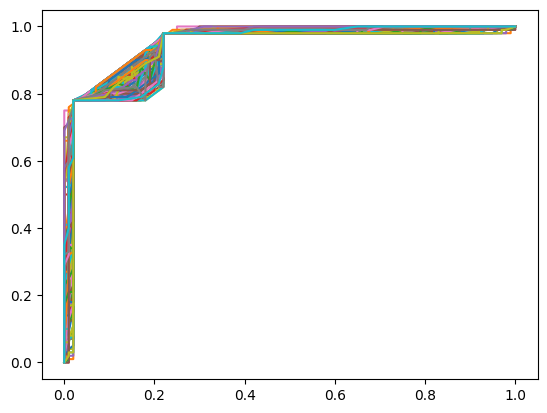

In [497]:
for fpr0, tpr0 in zip(fprs, tprs):
    plt.plot(fpr0, tpr0)

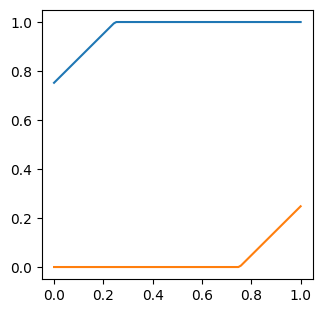

In [498]:
fprs = np.linspace(0, 1, 100)
tprs0 = np.maximum(np.minimum((max_acc * (p + n) - (1 - fprs)*n)/p, 1.0), 0.0)
tprs1 = np.maximum(np.minimum(((1 - max_acc) * (p + n) - (1 - fprs)*p)/n, 1.0), 0.0)

plt.figure(figsize=(3.5, 3.5))
plt.plot(fprs, tprs0)
plt.plot(fprs, tprs1)

(array([68662., 13216.,  4850.,  2256.,   189.,   818.,  1185.,   497.,
          422.,    79.]),
 array([  2. ,  17.7,  33.4,  49.1,  64.8,  80.5,  96.2, 111.9, 127.6,
        143.3, 159. ]),
 <BarContainer object of 10 artists>)

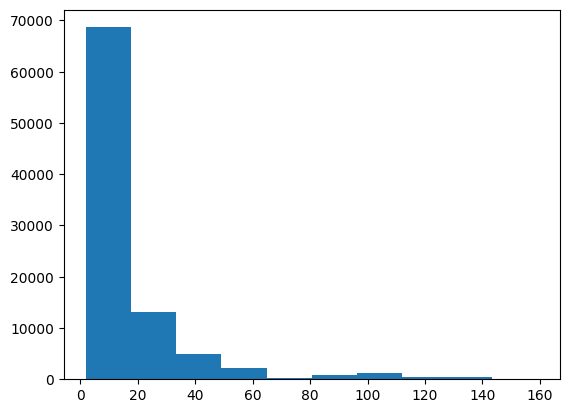

In [499]:
plt.hist(data['n_nodes'])

In [500]:
if equalize == 'auc':
    n_samples = 200

    tmp = []
    lower_bounds = np.linspace(0.5, 1.0, 11)
    lower_bounds_nodes = np.linspace(3, np.percentile(data['n_nodes'], 100), 11)
    for lower, upper in zip(lower_bounds[:-1], lower_bounds[1:]):
        if upper == 1.0:
            tmp2 = data[(data['auc'] >= lower) & (data['auc'] <= upper)]
        else:
            tmp2 = data[(data['auc'] >= lower) & (data['auc'] < upper)]
        for lowern, uppern in zip(lower_bounds_nodes[:-1], lower_bounds_nodes[1:]):
            if uppern == np.max(lower_bounds_nodes):
                tmp3 = tmp2[(tmp2['n_nodes'] >= lowern) & (tmp2['n_nodes'] <= uppern)]
            else:
                tmp3 = tmp2[(tmp2['n_nodes'] >= lowern) & (tmp2['n_nodes'] < uppern)]
                if len(tmp3) == 0:
                    continue
                if len(tmp3) > n_samples:
                    tmp.append(tmp3.sample(n_samples, random_state=5, replace=False))
                else:
                    tmp.append(tmp3.sample(n_samples, random_state=5, replace=True))
    data_eq = pd.concat(tmp)
else:
    data_eq = data

"""
if equalize == 'n_nodes_bins':
    n_samples = 1000

    tmp = []
    bins = data['n_nodes_bin'].drop_duplicates().values
    for bin in bins:
        tmp2 = data[data['n_nodes_bin'] == bin]
        if len(tmp2) > n_samples:
            tmp.append(tmp2.sample(n_samples, random_state=5, replace=False))
        else:
            tmp.append(tmp2.sample(n_samples, random_state=5, replace=True))
    data_eq = pd.concat(tmp)
else:
    data_eq = data
"""



if noedge:
    data_eq = data_eq[(~data_eq['best_sens'].isin([0])) & (~data_eq['best_spec'].isin([0]))]
    data_eq = data_eq[(~data_eq['sens'].isin([0])) & (~data_eq['spec'].isin([0]))]

    data = data[(~data['best_sens'].isin([0])) & (~data['best_spec'].isin([0]))]
    data = data[(~data['sens'].isin([0])) & (~data['spec'].isin([0]))]

(array([ 600.,  800.,  800., 1200., 1600., 1600., 1400., 1200., 1400.,
        1800.]),
 array([0.5 , 0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <BarContainer object of 10 artists>)

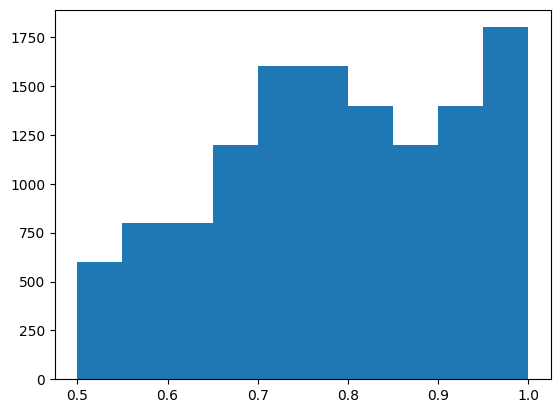

In [501]:
plt.hist(data_eq['auc'])

(array([1864., 1895., 1731., 1881., 1287.,  567., 1278.,  930.,  575.,
         392.]),
 array([  3.,  17.,  31.,  45.,  59.,  73.,  87., 101., 115., 129., 143.]),
 <BarContainer object of 10 artists>)

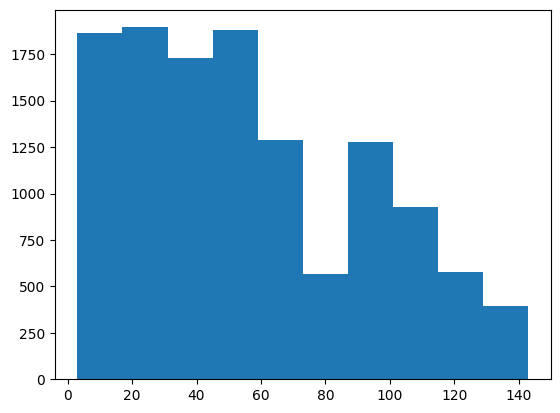

In [502]:
plt.hist(data_eq['n_nodes'])

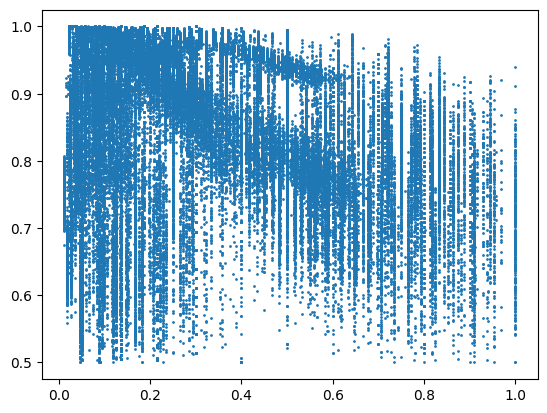

In [503]:
#plt.scatter(data['n_nodes']/(data['p'] + data['n']), data['auc'], s=1)
plt.scatter(data['n_nodes']/data.apply(lambda row: 2*min(row['p'], row['n']) + 2, axis=1), data['auc'], s=1)

In [525]:
def convex_hull_(fprs, tprs):
    hull = ConvexHull(np.vstack([np.hstack([fprs, [1.0]]), np.hstack([tprs, 0.0])]).T)
    vertices = hull.vertices[hull.vertices < len(fprs)]
    sorting = np.argsort(vertices)
    fprs_ch = fprs[vertices[sorting]]
    tprs_ch = tprs[vertices[sorting]]
    return fprs_ch, tprs_ch

def sample_latest(fpr0, tpr0, p, n, n_nodes=200, n_samples=10):
    n_nodes = min(min(p, n) * 2 + 2, 200)
    fpr1 = 1.0 - tpr0
    tpr1 = 1.0 - fpr0

    if fpr1 < fpr0:
        fpr0, tpr0, fpr1, tpr1 = fpr1, tpr1, fpr0, tpr0

    #fprs = np.sort(np.random.dirichlet(np.repeat(1.0, n_nodes), (n_samples)), axis=1)
    #tprs = np.sort(np.random.dirichlet(np.repeat(1.0, n_nodes), (n_samples)), axis=1)
    fprs = np.sort(np.random.random_sample((n_samples, n_nodes)), axis=1)
    tprs = np.sort(np.random.random_sample((n_samples, n_nodes)), axis=1)
    tprs = np.flip(tprs, axis=1)

    #fprs = np.vstack([np.repeat(0.0, n_samples), fprs.T, np.repeat(1.0, n_samples)]).T
    #tprs = np.vstack([np.repeat(1.0, n_samples), tprs.T, np.repeat(0.0, n_samples)]).T

    fprs = np.cumsum(fprs, axis=1)
    tprs = np.cumsum(tprs, axis=1)

    fprs = (fprs.T / fprs[:, -1]).T
    tprs = (tprs.T / tprs[:, -1]).T

    fprs = np.vstack([np.repeat(0.0, n_samples), fprs.T]).T
    tprs = np.vstack([tprs.T, np.repeat(0.0, n_samples)]).T

    #fprs = np.round(fprs * n) / n
    #tprs = np.round(tprs * p) / p

    fpr0_idx = np.argmin(np.abs(fprs - fpr0), axis=1)
    tpr0_idx = np.argmin(np.abs(tprs - tpr0), axis=1)
    fpr1_idx = np.argmin(np.abs(fprs - fpr1), axis=1)
    tpr1_idx = np.argmin(np.abs(tprs - tpr1), axis=1)

    #print(tprs)
    #print(fpr0_idx, tpr0_idx)
    #print(fprs[0], tprs[0])

    n_nodes_out = min(min(p, n) * 2 + 2, 200)
    """
    nodes = np.hstack([[0], np.sort(np.random.random_sample(n_nodes-1)), [1]])
    nodes = nodes.cumsum()
    nodes = nodes / nodes[-1]
    nodes = 
    """
    n_nodes_out = int(n_nodes_out / 3)

    r = np.sort(np.random.random_sample((n_samples, n_nodes_out)), axis=1).T
    #r = np.linspace(0, 1, 20)
    #r = np.tile(r, (n_samples, 1)).T
    fpr_samp0 = np.floor(r * fpr0_idx).astype(int).T

    r = np.sort(np.random.random_sample((n_samples, n_nodes_out)), axis=1).T
    tpr_samp0 = np.floor(r * tpr0_idx).astype(int).T

    r = np.sort(np.random.random_sample((n_samples, n_nodes_out)), axis=1).T
    fpr_samp1 = (np.floor(r * (fpr1_idx - fpr0_idx)).astype(int) + fpr0_idx).T

    r = np.sort(np.random.random_sample((n_samples, n_nodes_out)), axis=1).T
    tpr_samp1 = (np.floor(r * (tpr1_idx - tpr0_idx)).astype(int) + tpr0_idx).T

    r = np.sort(np.random.random_sample((n_samples, n_nodes_out)), axis=1).T
    fpr_samp2 = (np.floor(r * (n_nodes - fpr1_idx)).astype(int) + fpr1_idx).T

    r = np.sort(np.random.random_sample((n_samples, n_nodes_out)), axis=1).T
    tpr_samp2 = (np.floor(r * (n_nodes - tpr1_idx)).astype(int) + tpr1_idx).T

    fpr_samp0 = fprs[np.arange(n_samples)[:, None], fpr_samp0]
    tpr_samp0 = tprs[np.arange(n_samples)[:, None], tpr_samp0]
    fpr_samp1 = fprs[np.arange(n_samples)[:, None], fpr_samp1]
    tpr_samp1 = tprs[np.arange(n_samples)[:, None], tpr_samp1]
    fpr_samp2 = fprs[np.arange(n_samples)[:, None], fpr_samp2]
    tpr_samp2 = tprs[np.arange(n_samples)[:, None], tpr_samp2]

    fprs = np.hstack([fpr_samp0, fpr_samp1, fpr_samp2])
    tprs = np.hstack([tpr_samp0, tpr_samp1, tpr_samp2])

    fprs = np.vstack([np.repeat(0.0, n_samples), fprs.T, np.repeat(1.0, n_samples)]).T
    tprs = np.vstack([np.repeat(0.0, n_samples), tprs.T, np.repeat(1.0, n_samples)]).T

    fprs = np.round(fprs * n) / n
    tprs = np.round(tprs * p) / p

    return fprs, tprs

def sample_latest2(fpr0, tpr0, p, n, n_nodes=200, n_samples=10):
    fprs = np.sort(np.random.random_sample((n_samples, n_nodes)), axis=1)
    tprs = np.sort(np.random.random_sample((n_samples, n_nodes)), axis=1)
    tprs = np.flip(tprs, axis=1)

    fprs = np.round(fprs * n) / n
    tprs = np.round(tprs * p) / p

    fprs = np.vstack([np.repeat(0.0, n_samples), fprs.T, np.repeat(1.0, n_samples)]).T
    tprs = np.vstack([np.repeat(1.0, n_samples), tprs.T, np.repeat(0.0, n_samples)]).T

    fprs = np.cumsum(fprs, axis=1)
    tprs = np.cumsum(tprs, axis=1)

    fprs = (fprs.T / fprs[:, -1]).T
    tprs = (tprs.T / tprs[:, -1]).T

    fpr0_idx = np.argmin(np.abs(fprs - fpr0), axis=1)
    tpr0_idx = np.argmin(np.abs(tprs - tpr0), axis=1)

    #print(fpr0_idx[0], tpr0_idx[0])

    n_nodes_out = min(p, n) * 2 + 2
    n_nodes_out = int(n_nodes_out / 3)

    r = np.sort(np.random.random_sample((n_samples, n_nodes_out)), axis=1).T
    #r = np.linspace(0, 1, 20)
    #r = np.tile(r, (n_samples, 1)).T
    fpr_samp0 = np.floor(r * fpr0_idx).astype(int).T

    r = np.sort(np.random.random_sample((n_samples, n_nodes_out)), axis=1).T
    tpr_samp0 = np.floor(r * tpr0_idx).astype(int).T

    r = np.sort(np.random.random_sample((n_samples, n_nodes_out)), axis=1).T
    fpr_samp2 = (np.floor(r * (n_nodes - fpr0_idx)).astype(int) + fpr0_idx).T

    r = np.sort(np.random.random_sample((n_samples, n_nodes_out)), axis=1).T
    tpr_samp2 = (np.floor(r * (n_nodes - tpr0_idx)).astype(int) + tpr0_idx).T

    fpr_samp0 = fprs[np.arange(n_samples)[:, None], fpr_samp0]
    tpr_samp0 = tprs[np.arange(n_samples)[:, None], tpr_samp0]
    fpr_samp2 = fprs[np.arange(n_samples)[:, None], fpr_samp2]
    tpr_samp2 = tprs[np.arange(n_samples)[:, None], tpr_samp2]

    fprs = np.hstack([fpr_samp0, fpr_samp2])
    tprs = np.hstack([tpr_samp0, tpr_samp2])

    fprs = np.vstack([np.repeat(0.0, n_samples), fprs.T, np.repeat(1.0, n_samples)]).T
    tprs = np.vstack([np.repeat(0.0, n_samples), tprs.T, np.repeat(1.0, n_samples)]).T

    accs = np.any(((1.0 - fprs) * n + tprs * p) / (p + n) > ((1.0 - fpr0) * n + tpr0 * p) / (p + n), axis=1)

    return fprs[~accs], tprs[~accs]

def auc_latest(fpr0, tpr0, p, n, n_nodes=200, n_samples=10):
    fprs, tprs = sample_latest2(fpr0, tpr0, p, n, n_nodes, n_samples)
    if len(fprs) == 0:
        return (1 - fpr0 + tpr0)/2
    fprs = np.round(fprs*n)/n
    tprs = np.round(tprs*p)/p
    #aucs = [integrate_roc_curve(*convex_hull_(fprs1, tprs1)) for fprs1, tprs1 in zip(fprs, tprs)]
    aucs = [integrate_roc_curve(*(fprs1, tprs1)) for fprs1, tprs1 in zip(fprs, tprs)]
    #return np.percentile(aucs, ((1 - fpr0) + tpr0)/2*100)
    return np.percentile(aucs, (((1 - fpr0) + tpr0)/2 - 0.5)*2*100)

In [505]:
def convex_hull_area(fprs0, tprs0):
    hull = ConvexHull(np.vstack([np.hstack([fprs0, [1.0]]), np.hstack([tprs0, 0.0])]).T)
    vertices = hull.vertices[hull.vertices < len(fprs0)]
    sorting = np.argsort(vertices)
    fprs_ch = fprs0[vertices[sorting]]
    tprs_ch = tprs0[vertices[sorting]]
    return integrate_roc_curve(fprs_ch, tprs_ch)

In [506]:
def convex_hull_curve(fprs0, tprs0, fpr1, tpr1, p, n, best=False):
    """
    Returns the convex hull of the ROC curve fprs0, tprs0

    Args:
        fprs0 (np.array): the fpr values of the curve
        tprs0 (np.array): the tpr values of the curve
        fpr1 (float): the known fpr point of the curve
        tpr1 (float): the known tpr point of the curve
        p (int): the number of positives
        n (int): the number of negatives
    
    Returns:
        np.array, np.array, bool: the fpr and tpr coordinates of the convex hull,
                                    and a flag indicating whether the known point is
                                    on the convex hull curve
    """
    hull = ConvexHull(np.vstack([np.hstack([fprs0, [1.0]]), np.hstack([tprs0, 0.0])]).T)
    vertices = hull.vertices[hull.vertices < len(fprs0)]
    sorting = np.argsort(vertices)
    fprs_ch = fprs0[vertices[sorting]]
    tprs_ch = tprs0[vertices[sorting]]

    points = np.vstack([fprs_ch, tprs_ch]).T
    
    # determining the closest point of the path
    diffs = np.sum((points - np.array([fpr1, tpr1]))**2, axis=1)
    idx = np.argmin(diffs)

    flag = np.abs(fprs_ch[idx] - fpr1) < 1/n and np.abs(tprs_ch[idx] - tpr1) < 1/p
    if idx > 0 and idx < len(fprs_ch)-1:
        slope_a = (tprs_ch[idx+1] - tprs_ch[idx-1])/(fprs_ch[idx+1] - fprs_ch[idx-1])
    else:
        slope_a = 1

    diffs = np.sum((points - np.array([1.0 - tpr1, 1.0 - fpr1]))**2, axis=1)
    idx = np.argmin(diffs)

    flag = flag and (np.abs(fprs_ch[idx] - (1.0 - tpr1)) < 1/n and np.abs(tprs_ch[idx] - (1.0 - fpr1)) < 1/p)
    if idx > 0 and idx < len(fprs_ch)-1:
        slope_b = (tprs_ch[idx+1] - tprs_ch[idx-1])/(fprs_ch[idx+1] - fprs_ch[idx-1])
    else:
        slope_b = 1

    if fpr1 + tpr1 < 1.0:
        flag = flag and slope_a >= 1
        flag = flag and slope_b <= 1

        #if slope_a < 0 or slope_b > 1:
        #    print(slope_a, slope_b)
    else:
        flag = flag and slope_a <= 1
        flag = flag and slope_b >= 1
        #if slope_a > 0 or slope_b < 1:
        #    print(slope_a, slope_b)

    if best:
        flag = flag and np.all((p*tprs_ch + n*(1.0 - fprs_ch))/(p + n) <= (p*tpr1 + n*(1 - fpr1))/(p + n))
        #print(np.all((p*tprs_ch + n*(1.0 - fprs_ch))/(p + n) <= (p*tpr1 + n*(1 - fpr1))/(p + n)))

    return fprs_ch, tprs_ch, flag

In [507]:
def convex_hull_curve0(fprs0, tprs0):
    """
    Returns the convex hull of the ROC curve fprs0, tprs0

    Args:
        fprs0 (np.array): the fpr values of the curve
        tprs0 (np.array): the tpr values of the curve
        fpr1 (float): the known fpr point of the curve
        tpr1 (float): the known tpr point of the curve
        p (int): the number of positives
        n (int): the number of negatives
    
    Returns:
        np.array, np.array, bool: the fpr and tpr coordinates of the convex hull,
                                    and a flag indicating whether the known point is
                                    on the convex hull curve
    """
    hull = ConvexHull(np.vstack([np.hstack([fprs0, [1.0]]), np.hstack([tprs0, 0.0])]).T)
    vertices = hull.vertices[hull.vertices < len(fprs0)]
    sorting = np.argsort(vertices)
    fprs_ch = fprs0[vertices[sorting]]
    tprs_ch = tprs0[vertices[sorting]]

    
    return fprs_ch, tprs_ch

In [508]:
def sample_roc_curves(fpr, tpr, n_samples, n_nodes, p, n, mode, random_state):
    if not isinstance(random_state, np.random.RandomState):
        random_state = np.random.RandomState(random_state)

    if n_nodes == 'max':
        n_nodes = np.array([min(p, n) * 2 + 2])
        n_blocks = np.array([n_samples])
    elif n_nodes == 'random':
        n_nodes = random_state.choice(np.arange(3, min(p, n)*2 + 2), n_samples)
        n_nodes, n_blocks = np.unique(n_nodes, return_counts=True)
    elif isinstance(n_nodes, int):
        n_nodes = np.array([n_nodes])
        n_blocks = np.array([n_samples])
    elif isinstance(n_nodes, list) or isinstance(n_nodes, np.array):
        n_nodes = np.array(n_nodes)
        n_blocks = np.repeat(int(n_samples/len(n_nodes)), len(n_nodes))

    max_acc = (p*tpr + n*(1 - fpr))/(p + n)

    fprs, tprs = [], []
    for nodes, block in zip(n_nodes, n_blocks):
        fprs0, tprs0 = sample1(fpr, tpr, block, nodes, p=p, n=n, max_acc=max_acc, mode=mode, random_state=random_state)
        fprs.extend(fprs0)
        tprs.extend(tprs0)
    
    return fprs, tprs

In [509]:
def auc_ch_(spec, sens, p, n, true_auc=None, mode='min-max', n_samples=1000, n_nodes=100, best=False, agg=None, random_state=5):

    fprs, tprs = sample_roc_curves(1 - spec, sens, n_samples, n_nodes, p=p, n=n, mode=mode, random_state=random_state)

    curves_ch = [convex_hull_curve(fprs0, tprs0, 1 - spec, sens, p=p, n=n, best=best) for fprs0, tprs0 in zip(fprs, tprs)]

    fprs_ch, tprs_ch, flags = list(zip(*curves_ch))

    for fprs0, tprs0, flag, fprs1, tprs1 in zip(fprs_ch, tprs_ch, flags, fprs, tprs):
        if not flag:
            plt.plot(fprs0, tprs0, c='red')
            plt.plot(fprs1, tprs1, c='black')
    plt.scatter([1 - spec], [sens])

    fprs_ch = [fprs0 for fprs0, flag in zip(fprs_ch, flags) if flag]
    tprs_ch = [tprs0 for tprs0, flag in zip(tprs_ch, flags) if flag]

    aucs_ch = np.array([integrate_roc_curve(fprs0, tprs0) for (fprs0, tprs0) in zip(fprs_ch, tprs_ch)])

    #print(spec, sens, aucs_ch)

    aucs = aucs_ch

    #if len(aucs) == 0:
    #    return (sens + spec)/2, -1

    #auc = aucs[min(int(len(aucs) * min(((sens + spec)/2), 1)), len(aucs)-1)]

    #perc = -1

    #if true_auc is not None:
    #    perc = np.argmin(np.abs(aucs - true_auc))/len(aucs)

    return aucs

array([], dtype=float64)

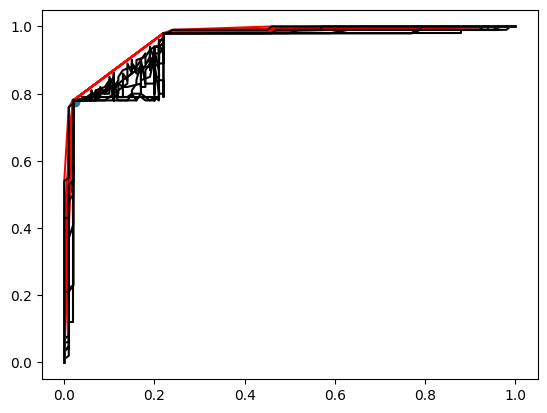

In [510]:
auc_ch_(0.976, 0.776, 100, 100, mode='mina-maxa', n_samples=10, n_nodes=100, best=True, agg=None, random_state=5)

In [511]:
def sample_average4(avg, n, random_state):
    sample = np.repeat(avg, n)
    coords = np.arange(n)

    iter = 0
    while True:
        idx, jdx = random_state.choice(coords, 2, replace=False)
        if random_state.randint(2) == 1:
            idx, jdx = jdx, idx
        lower = sample[idx]
        upper = 1.0 - sample[jdx]
        d = min(lower, upper)

        step = random_state.random_sample() * d * 0.7

        sample[idx] = sample[idx] - step
        sample[jdx] = sample[jdx] + step

        iter += 1

        if iter > 50 and not np.any(sample > 1) and not np.any(sample < 0):
            return sample
        elif iter > 50:
            iter = 0
            sample = np.repeat(avg, n)

In [512]:
def auc_ch(spec, sens, p, n, true_auc=None, mode='min-max', n_samples=1000, n_nodes=100, best=False, agg=None, random_state=5):
    if agg is None:
        aucs = auc_ch_(spec, sens, p, n, true_auc, mode, n_samples, n_nodes, best, agg, random_state)

        if len(aucs) == 0:
            print('exc')
            return (spec + sens)/2.0, -1
    
        perc = (spec + sens)/2.0
        aucs = np.sort(aucs)

        return aucs[min(int(len(aucs)*perc), len(aucs)-1)], perc
    else:
    
        random_state = np.random.RandomState(5)

        results = []

        n_tmp = int(n_samples/5)

        for _ in range(n_tmp):

            specs = sample_average4(spec, agg, random_state)
            senss = sample_average4(sens, agg, random_state)

            tmp = []
            for spec0, sens0 in zip(specs, senss):
                #max(int(n_samples/(n_tmp*len(specs))), 1)
                aucs = auc_ch_(spec0, sens0, p, n, true_auc, mode, 50, n_nodes, best, agg=None, random_state=random_state)

                if len(aucs) > 0:
                    aucs = np.sort(np.array(aucs))

                    perc = (spec0 + sens0)/2.0

                    tmp.append(aucs[min(int(len(aucs)*perc), len(aucs)-1)])
                else:
                    tmp.append((spec0 + sens0)/2.0)

            #print(tmp)
            """
            n_min = np.min([len(tmp[idx]) for idx in range(len(tmp))])
            for idx in range(len(tmp)):
                tmp[idx] = tmp[idx][:n_min]
            """
            
            #tmp = np.array(tmp)
            auc = np.mean(tmp)

            #print(specs, senss, aucs)

            results.append(auc)

            
        #aucs = np.sort(np.array(results))

        #print(aucs)

        #perc = (spec + sens)/2.0

        #if len(aucs) > 0:
            #auc = aucs[min(int(len(aucs)*perc), len(aucs)-1)]
        #else:
            #auc = (spec + sens)/2.0

        #results.append(auc)

        return np.median(results), -1


    

(np.float64(0.9641319757277778), -1)

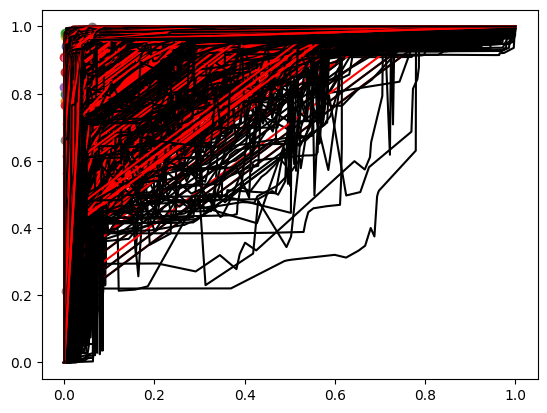

In [431]:
auc_ch(0.976, 0.776, 30000, 300000, true_auc=None, mode='min-max', n_samples=100, n_nodes=50, best=False, agg=5, random_state=7)

(np.float64(0.9686999999999999), 0.8674999999999999)

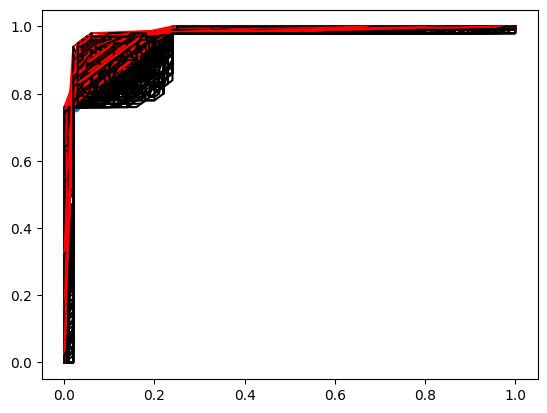

In [432]:
auc_ch(0.976, 0.759, 100, 100, true_auc=None, mode='min-max', n_samples=1000, n_nodes=100, best=False, agg=None, random_state=1)

In [433]:
sample_average4(0.776, 5, np.random.RandomState(7))

array([0.93734304, 0.45464863, 0.90984414, 0.78758583, 0.79057836])

In [434]:
def max_acc_ch(auc, p, n, true_max_acc=None, n_samples=1000, n_nodes=100, random_state=5):
    fprs, tprs = sample1_unconstrained(n_samples, n_nodes, p, n, random_state)
    curves_ch = [convex_hull_curve0(fprs0, tprs0) for (fprs0, tprs0) in zip(fprs, tprs)]
    fprs = [tmp[0] for tmp in curves_ch]
    tprs = [tmp[1] for tmp in curves_ch]

    aucs = np.array([integrate_roc_curve(fprs0, tprs0) for (fprs0, tprs0) in zip(fprs, tprs)])
    diffs = np.abs(aucs - auc)
    sorting = np.argsort(diffs)

    diffs = diffs[sorting]
    fprs = [fprs[idx] for idx in sorting]
    tprs = [tprs[idx] for idx in sorting]
    aucs = aucs[sorting]

    mask = diffs < 1/(p*n)

    flag = False
    
    if np.sum(mask) == 0:
        mask[0] = True
        flag = True

    fprs = [fprs[idx] for idx in range(len(mask)) if mask[idx]]
    tprs = [tprs[idx] for idx in range(len(mask)) if mask[idx]]

    accs = [np.max((p*tpr0 + (1 - fpr0)*n)/(p + n)) for fpr0, tpr0 in zip(fprs, tprs)]

    return np.median(accs), flag

In [435]:
def sample_average(avg, n, random_state):
    sample = np.diff(np.hstack([[0], np.sort(random_state.random_sample(n-1)), [1]]))
    sample = sample * avg * n
    if np.any(sample > 1):
        return sample_average(avg, n, random_state)
    return sample

In [436]:
def sample_average2(avg, n, random_state):
    xs = []

    total = 100*n

    while n > 1:
        lower = max(1.0 - (1.0 - avg) * n, 0.0)
        upper = min(avg * n, 1.0)

        tmp = random_state.exponential(total)
        while not (lower <= tmp <= upper):
            tmp = random_state.exponential(total)

        #xs.append(random_state.random_sample() * (upper - lower) + lower)
        xs.append(tmp)

        if n == 1:
            break

        avg = (avg * n - xs[-1]) / (n - 1)
        n = n - 1
    
    xs.append(avg)

    sample = np.array(xs)
    random_state.shuffle(sample)

    return sample

In [437]:
def sample_average3(avg, n, random_state):
    sample = random_state.exponential(n, n)
    return sample / np.mean(sample)*avg

In [438]:
random_state = np.random.RandomState(5)

In [439]:
sample_average4(0.8, 3, random_state)

array([0.54279288, 0.91824747, 0.93895965])

In [440]:
samples = np.array([sample_average4(0.99, 20, random_state) for idx in range(1000)])
samples

array([[0.98665987, 0.99657548, 0.9917351 , ..., 0.99571902, 0.98291054,
        0.99536486],
       [0.98390554, 0.996327  , 0.97516103, ..., 0.9975373 , 0.98931475,
        0.99462649],
       [0.99692397, 0.9932346 , 0.98688825, ..., 0.99811439, 0.99782939,
        0.98550732],
       ...,
       [0.99796686, 0.99970034, 0.98883782, ..., 0.99799621, 0.9932196 ,
        0.98684514],
       [0.99128439, 0.9948722 , 0.99863763, ..., 0.96980042, 0.99502343,
        0.99832759],
       [0.99441895, 0.99583281, 0.98743906, ..., 0.9907782 , 0.99839456,
        0.98183608]])

In [441]:
samples2 = 1.0 - (1.0 - samples)*0.02
samples2 = samples / 1.5

In [442]:
import plotly.graph_objs as go
import plotly.offline as py

In [443]:
"""trace = go.Scatter3d(x=samples[:, 0], y=samples[:, 1], z=samples[:, 2], mode='markers')
fig = go.Figure(data=[trace])
fig.update_traces(marker={'size': 2})
py.iplot(fig)"""

"trace = go.Scatter3d(x=samples[:, 0], y=samples[:, 1], z=samples[:, 2], mode='markers')\nfig = go.Figure(data=[trace])\nfig.update_traces(marker={'size': 2})\npy.iplot(fig)"

In [444]:
"""trace = go.Scatter3d(x=samples2[:, 0], y=samples2[:, 1], z=samples2[:, 2], mode='markers')
fig = go.Figure(data=[trace])
fig.update_traces(marker={'size': 2})
py.iplot(fig)"""

"trace = go.Scatter3d(x=samples2[:, 0], y=samples2[:, 1], z=samples2[:, 2], mode='markers')\nfig = go.Figure(data=[trace])\nfig.update_traces(marker={'size': 2})\npy.iplot(fig)"

In [513]:
#data_sample = data_eq[(data_eq['n_nodes'] > 2) & (~data_eq['edge_case']) & (~data_eq['best_edge_case'])]
data_sample = data_eq[(~data_eq['sens'].isin([0, 1])) & (~data_eq['spec'].isin([0, 1]))]
data_sample = data_sample.sample(4000)

In [ ]:
row = data.iloc[0]
auc, prec = auc_ch(row['spec'], row['sens'], row['p'], row['n'], row['auc'], mode='min-max')
print(auc, (row['auc_min'] + row['auc_max'])/2, row['auc'], row['sens'], row['spec'], row['auc_max'], row['auc_integral_roc'], row['p'], row['n'])

0.6487758620689655 0.6216674416802294 0.6216674416802294 0.7057531840140536 0.5375816993464052 0.8639348873790477 0.6770423606012961 200 145


In [ ]:
len(data_eq)

11000

In [ ]:
data_sample[['max_acc_new', 'max_acc_flag']] = data_sample.apply(lambda row: max_acc_ch(row['auc'], row['p'], row['n'], n_samples=1000, n_nodes=50, random_state=5), axis=1, result_type='expand')

In [ ]:
tmp = data_sample

In [ ]:
r2_score(tmp['best_acc'], tmp['max_acc_new'])

0.899331954102827

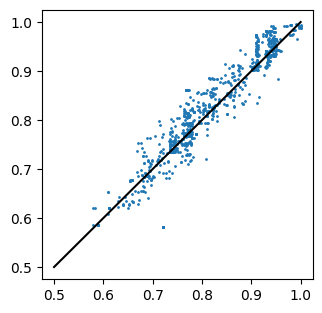

In [ ]:
plt.figure(figsize=(3.5, 3.5))
plt.scatter(tmp['best_acc'], tmp['max_acc_new'], s=1)
plt.plot([0.5, 1], [0.5, 1], color='black')

In [ ]:
skew(data_sample['best_acc'] - data_sample['max_acc_new']), skewtest(data_sample['best_acc'] - data_sample['max_acc_new'])

(np.float64(1.03919077133757),
 SkewtestResult(statistic=np.float64(11.306496052294888), pvalue=np.float64(1.2185935106642286e-29)))

In [514]:
data_sample['auc_min_max'] = (data_sample['auc_min'] + data_sample['auc_max']) / 2.0

In [ ]:
data_sample[['auc_new', 'p_value']] = data_sample.apply(lambda row: auc_ch(row['spec'], row['sens'], row['p'], row['n'], row['auc'], mode='min-max', n_samples=1000, n_nodes=100), axis=1, result_type='expand')

In [ ]:
data_sample[['auc_new_agg', 'p_value_agg']] = data_sample.apply(lambda row: auc_ch(row['spec'], row['sens'], row['p'], row['n'], row['auc'], agg=row['k'], mode='min-max', n_samples=100, n_nodes=50), axis=1, result_type='expand')

In [ ]:
def auc8(fpr, tpr):
    if tpr + fpr > 1:
        tpr, fpr = 1 - fpr, 1 - tpr
    
    return -tpr**2/2 + fpr**2/2 + 0.5 + tpr - fpr
    #return tpr / (tpr + fpr)

In [ ]:
data_sample['auc8'] = data_sample.apply(lambda row: auc8(1.0 - row['spec'], row['sens']), axis=1)

In [515]:
data_sample['auc_latest'] = data_sample.apply(lambda row: auc_latest(1.0 - row['spec'], row['sens'], row['p'], row['n'], 100, 1000), axis=1)

In [516]:
(r2_score(data_sample['auc'], data_sample['auc_min_max']), 
 r2_score(data_sample['auc'], data_sample['auc_integral_roc']), 
 #r2_score(data_sample['auc'], data_sample['auc_new']),
 #r2_score(data_sample['auc'], data_sample['auc_new_agg']),
 r2_score(data_sample['auc'], data_sample['auc_latest']),
 r2_score(data_sample['auc'], (data_sample['auc_latest'] + data_sample['auc_integral_roc'])/2),
 r2_score(data_sample['auc'], (data_sample['auc_min_max']**0.7)),
 #r2_score(data_sample['auc'], data_sample['auc8'])
 )

(0.692025766757493,
 0.8819323008316728,
 0.8896519682157995,
 0.8911464578248228,
 0.850845421309411)

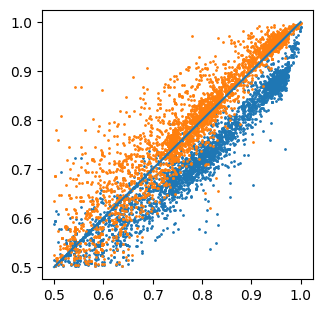

In [518]:
plt.figure(figsize=(3.5, 3.5))
plt.scatter(data_sample['auc'], data_sample['auc_min_max'], s=1)
plt.scatter(data_sample['auc'], data_sample['auc_integral_roc'], s=1)
#plt.scatter(data_sample['auc'], data_sample['auc_new'], s=1)
#plt.scatter(data_sample['auc'], data_sample['auc_new_agg'], s=1)
#plt.scatter(data_sample['auc'], data_sample['auc_latest'], s=1)
#plt.scatter(data_sample['auc'], (data_sample['auc_integral_roc'] + data_sample['auc_latest'])/2, s=1)
#plt.scatter(data_sample['auc'], data_sample['auc8'], s=1)
plt.plot([0.5, 1], [0.5, 1])
plt.show()

In [ ]:
data_sample[(data_sample['auc'] < 0.6) & (data_sample['auc_latest'] > 0.7)][['sens', 'spec', 'auc', 'auc_latest', 'auc_integral_roc', 'p', 'n']]

,sens,spec,auc,auc_latest,auc_integral_roc,p,n
97603,0.922222,0.300000,0.541111,0.74850,0.732233,90,10
4022,0.586957,0.625000,0.596467,0.71500,0.651319,46,16
38155,0.575000,0.620690,0.585345,0.70250,0.640499,40,29
92195,0.944444,0.500000,0.513889,0.86375,0.867357,18,4
99538,0.100000,0.966667,0.534444,0.74625,0.640499,10,90
95001,0.200000,0.956522,0.576651,0.76250,0.720567,15,207
57621,0.200000,0.942029,0.517552,0.74350,0.689900,15,207
52522,0.869565,0.375000,0.580163,0.73125,0.715461,46,16
88353,0.200000,0.951691,0.582931,0.75250,0.709425,15,207
32553,0.500000,0.944444,0.500000,0.86125,0.867357,4,18


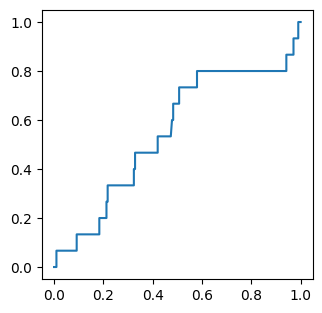

In [ ]:
plt.figure(figsize=(3.5, 3.5))
fprs, tprs = data_sample.loc[37382][['fprs', 'tprs']]
plt.plot(eval(fprs), eval(tprs))

In [ ]:
data_sample[(data_sample['auc_new'] < 0.5)][['sens', 'spec', 'auc', 'n_nodes', 'auc_new', 'p', 'n']]

,sens,spec,auc,n_nodes,auc_new,p,n


In [ ]:
data_sample[(data_sample['auc'] > 0.8) & (data_sample['auc_new'] < 0.7)][['auc', 'sens', 'spec', 'auc_new', 'dataset', 'classifier']]

,auc,sens,spec,auc_new,dataset,classifier
46356,0.899606,0.159581,1.000000,0.685427,SATIMAGE,KNeighborsClassifier
41583,0.898824,0.144602,1.000000,0.677776,SATIMAGE,KNeighborsClassifier
42712,0.898904,0.129284,1.000000,0.668881,SATIMAGE,KNeighborsClassifier
42493,0.898423,1.000000,0.178344,0.693322,SATIMAGE,KNeighborsClassifier
42493,0.898423,1.000000,0.178344,0.693322,SATIMAGE,KNeighborsClassifier
539,0.900524,1.000000,0.159751,0.682992,SATIMAGE,KNeighborsClassifier
53,0.898631,1.000000,0.141158,0.673694,SATIMAGE,KNeighborsClassifier
41583,0.898824,0.144602,1.000000,0.677776,SATIMAGE,KNeighborsClassifier
46356,0.899606,0.159581,1.000000,0.685427,SATIMAGE,KNeighborsClassifier
53,0.898631,1.000000,0.141158,0.673694,SATIMAGE,KNeighborsClassifier


In [ ]:
tpr = 0.833
fpr = 0.75
min(max(tpr, fpr), max(1 - tpr, 1 - fpr)) / 2 + 0.5

0.625

(array([  7.,   0.,   0.,   5.,  29., 224., 112.,   2.,   7.,  14.]),
 array([-0.27312307, -0.222102  , -0.17108094, -0.12005988, -0.06903882,
        -0.01801776,  0.0330033 ,  0.08402436,  0.13504542,  0.18606648,
         0.23708754]),
 <BarContainer object of 10 artists>)

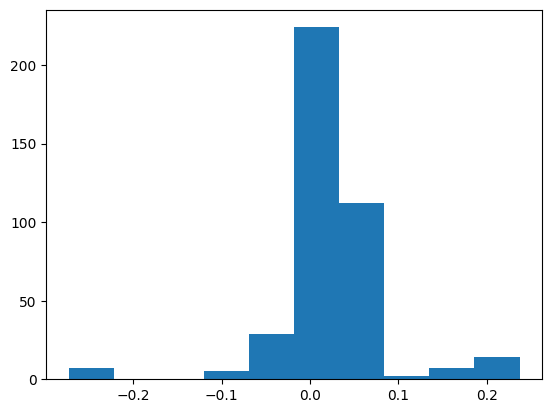

In [ ]:
plt.hist(data_sample['auc'] - data_sample['auc_new'])

In [ ]:
skew(data_sample['auc'] - data_sample['auc_new'])

np.float64(-0.809249782452838)

In [ ]:
skewtest(data_sample['auc'] - data_sample['auc_new'])

SkewtestResult(statistic=np.float64(-5.970235992738273), pvalue=np.float64(2.3691065391314316e-09))

In [367]:
data_sample['auc_min_max'] = (data_sample['auc_min_best'] + data_sample['auc_max_best']) / 2.0

In [ ]:
data_sample[['auc_new', 'p_value']] = data_sample.apply(lambda row: auc_ch(row['best_spec'], row['best_sens'], row['p'], row['n'], row['auc'], mode='mina-maxa', n_samples=1000, n_nodes=100, best=True), axis=1, result_type='expand')

exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc
exc


KeyboardInterrupt: 

In [519]:
tmp = data_sample#[~data_sample['best_edge_case']]

In [486]:
tmp = data_sample[(~data_sample['best_sens'].isin([0, 1])) & (~data_sample['best_spec'].isin([0, 1]))].copy()

In [520]:
tmp['auc_min_max'] = (tmp['auc_min_best'] + tmp['auc_max_best']) / 2.0

In [526]:
tmp['auc_latest'] = tmp.apply(lambda row: auc_latest(1.0 - row['best_spec'], row['best_sens'], p=row['p'], n=row['n'], n_nodes=100, n_samples=1000), axis=1)

In [527]:
(r2_score(tmp['auc'], tmp['auc_min_max']), 
 r2_score(tmp['auc'], tmp['auc_integral_roc_best']), 
 r2_score(tmp['auc'], tmp['auc_latest']), 
 #r2_score(tmp['auc'], tmp['auc_new']),
 r2_score(tmp['auc'], (tmp['auc_min_max'] + tmp['auc_integral_roc_best'])/2),
 #r2_score(tmp['auc'], (tmp['auc_min_max'] + tmp['auc_new'])/2),
 #r2_score(tmp['auc'], (tmp['auc_new'] + tmp['auc_integral_roc_best'])/2),
 r2_score(tmp['auc'], (tmp['auc_min_max'])**0.7))

(0.17191015146471533,
 0.7416101680496475,
 0.7549465584532465,
 0.7451169508073745,
 0.6730893147770516)

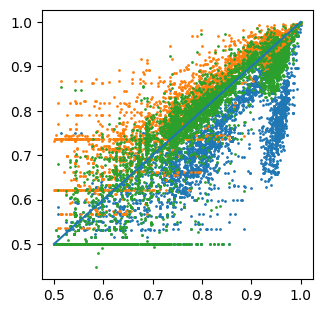

In [528]:
plt.figure(figsize=(3.5, 3.5))
plt.scatter(tmp['auc'], tmp['auc_min_max'], s=1)
plt.scatter(tmp['auc'], tmp['auc_integral_roc_best'], s=1)
#plt.scatter(tmp['auc'], tmp['auc_new'], s=1)
plt.scatter(tmp['auc'], tmp['auc_latest'], s=1)
#plt.scatter(tmp['auc'], (tmp['auc_min_max'] + tmp['auc_integral_roc_best'])/2, s=1)
plt.plot([0.5, 1], [0.5, 1])

In [479]:
tmp2 = tmp[(tmp['auc'] > 0.6) & (tmp['auc_latest'] < 0.6)][['best_sens', 'best_spec', 'p', 'n', 'k', 'auc', 'auc_latest', 'dataset', 'classifier']]

In [480]:
tmp2

,best_sens,best_spec,p,n,k,auc,auc_latest,dataset,classifier
20548,0.927228,0.262404,302,160,3,0.721771,0.594816,saheart,RandomForestClassifier
32427,0.891176,0.294160,302,160,6,0.706712,0.592668,saheart,XGBClassifier
47285,0.995536,0.049695,225,81,2,0.634680,0.522615,haberman,XGBClassifier
49045,0.995000,0.095890,200,145,2,0.640203,0.545445,bupa,RandomForestClassifier
39217,0.930000,0.269216,200,145,2,0.640004,0.599608,bupa,SVC
...,...,...,...,...,...,...,...,...,...
33122,0.193018,0.945000,145,200,2,0.631588,0.569009,bupa,RandomForestClassifier
609,0.943529,0.179962,302,160,6,0.687247,0.561746,saheart,XGBClassifier
20777,0.943454,0.230937,302,160,9,0.676420,0.587195,saheart,XGBClassifier
10257,0.995614,0.024725,225,81,6,0.689578,0.510170,haberman,RandomForestClassifier


In [ ]:
tmp1 = tmp[['best_sens', 'best_spec', 'auc', 'auc_new', 'n_nodes', 'fprs', 'tprs', 'p', 'n']]

KeyError: "['auc_new'] not in index"

In [ ]:
tmp1

,best_sens,best_spec,auc,auc_new,n_nodes,fprs,tprs,p,n
39435,1.000000,0.000000,0.506315,0.614678,8,"[0.0, 0.6386860126297687, 0.6551062199618295, ...","[0.0, 0.6444444444444445, 0.6666666666666666, ...",225,81
39435,1.000000,0.000000,0.506315,0.614678,8,"[0.0, 0.6386860126297687, 0.6551062199618295, ...","[0.0, 0.6444444444444445, 0.6666666666666666, ...",225,81
18126,1.000000,0.000000,0.508322,0.629653,13,"[0.0, 0.5, 0.6666666666666666, 0.6666666666666...","[0.0, 0.5173098069426886, 0.6532880759235847, ...",449,49
8931,0.925439,0.490196,0.508772,0.769060,64,"[0.0, 0.0, 0.0196078431372549, 0.0196078431372...","[0.0, 0.4166666666666667, 0.4166666666666667, ...",228,204
8931,0.925439,0.490196,0.508772,0.769060,64,"[0.0, 0.0, 0.0196078431372549, 0.0196078431372...","[0.0, 0.4166666666666667, 0.4166666666666667, ...",228,204
...,...,...,...,...,...,...,...,...,...
8931,0.925439,0.490196,0.508772,0.769060,64,"[0.0, 0.0, 0.0196078431372549, 0.0196078431372...","[0.0, 0.4166666666666667, 0.4166666666666667, ...",228,204
8931,0.925439,0.490196,0.508772,0.769060,64,"[0.0, 0.0, 0.0196078431372549, 0.0196078431372...","[0.0, 0.4166666666666667, 0.4166666666666667, ...",228,204
8931,0.925439,0.490196,0.508772,0.769060,64,"[0.0, 0.0, 0.0196078431372549, 0.0196078431372...","[0.0, 0.4166666666666667, 0.4166666666666667, ...",228,204
8931,0.925439,0.490196,0.508772,0.769060,64,"[0.0, 0.0, 0.0196078431372549, 0.0196078431372...","[0.0, 0.4166666666666667, 0.4166666666666667, ...",228,204


In [ ]:
fprs2, tprs2 = tmp1.iloc[80][['fprs', 'tprs']]

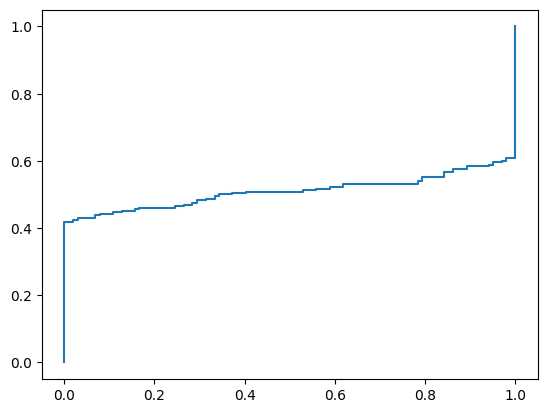

In [ ]:
plt.plot(eval(fprs2), eval(tprs2))

(array([ 529.,  422.,  335.,  300.,  419.,  555.,  615., 1467., 2446.,
        3912.]),
 array([0.    , 0.0999, 0.1998, 0.2997, 0.3996, 0.4995, 0.5994, 0.6993,
        0.7992, 0.8991, 0.999 ]),
 <BarContainer object of 10 artists>)

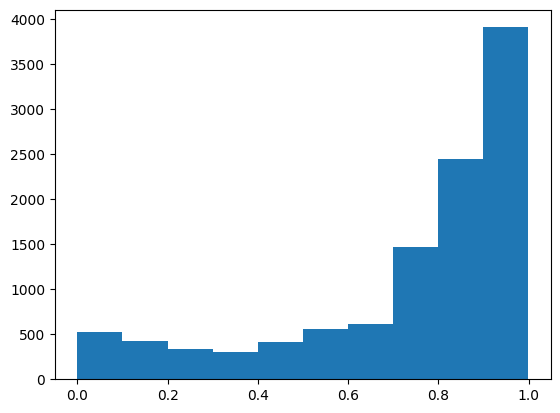

In [ ]:
plt.hist(data_sample['p_value'])

In [ ]:
tmp[(tmp['auc'] > 0.6) & (tmp['auc_new'] < 0.55)][['p', 'n', 'best_sens', 'best_spec', 'auc', 'auc_new', 'auc_integral_roc']]

,p,n,best_sens,best_spec,auc,auc_new,auc_integral_roc


In [ ]:
row = data_sample.loc[27997]
auc, prec = estimate(row['best_spec'], row['best_sens'], row['p'], row['n'], row['auc'], mode='rmin-maxa', best=True)
print(auc, (row['auc_min'] + row['auc_max'])/2, row['auc'], row['best_sens'], row['best_spec'])

KeyError: 27997

In [ ]:
tmp[(tmp['auc'] > 0.55) & (tmp['auc_new'] < 0.55)][['p', 'n', 'auc_new', 'p_value', 'auc_maxa_best', 'auc_max_best', 'auc_min_max', 'auc_integral_roc_best', 'best_sens', 'best_spec', 'auc']].sort_values('auc')

,p,n,auc_new,p_value,auc_maxa_best,auc_max_best,auc_min_max,auc_integral_roc_best,best_sens,best_spec,auc
74808,40,29,0.524569,0.707107,0.637500,1.0,0.5,0.53528,1.0,0.0,0.553879
21710,29,40,0.522845,0.707107,0.637500,1.0,0.5,0.53528,0.0,1.0,0.571121
13877,61,32,0.547131,0.707107,0.737705,1.0,0.5,0.56741,1.0,0.0,0.595799
13877,61,32,0.548412,0.707107,0.737705,1.0,0.5,0.56741,1.0,0.0,0.595799
13877,61,32,0.548156,0.707107,0.737705,1.0,0.5,0.56741,1.0,0.0,0.595799
13877,61,32,0.549436,0.707107,0.737705,1.0,0.5,0.56741,1.0,0.0,0.595799
13877,61,32,0.548924,0.707107,0.737705,1.0,0.5,0.56741,1.0,0.0,0.595799


In [ ]:
data_sample[(data_sample['auc'] > 0.55) & (data_sample['auc_new'] < 0.55)][['p', 'n', 'auc_new', 'p_value', 'auc_maxa_best', 'auc_max_best', 'auc_min_max', 'auc_integral_roc_best', 'best_sens', 'best_spec', 'auc']].sort_values('auc')

,p,n,auc_new,p_value,auc_maxa_best,auc_max_best,auc_min_max,auc_integral_roc_best,best_sens,best_spec,auc
74808,40,29,0.524569,0.707107,0.637500,1.0,0.5,0.53528,1.0,0.0,0.553879
21710,29,40,0.522845,0.707107,0.637500,1.0,0.5,0.53528,0.0,1.0,0.571121
13877,61,32,0.547131,0.707107,0.737705,1.0,0.5,0.56741,1.0,0.0,0.595799
13877,61,32,0.548412,0.707107,0.737705,1.0,0.5,0.56741,1.0,0.0,0.595799
13877,61,32,0.548156,0.707107,0.737705,1.0,0.5,0.56741,1.0,0.0,0.595799
13877,61,32,0.549436,0.707107,0.737705,1.0,0.5,0.56741,1.0,0.0,0.595799
13877,61,32,0.548924,0.707107,0.737705,1.0,0.5,0.56741,1.0,0.0,0.595799


In [ ]:
row = data.iloc[23]

In [ ]:
aucs = integrate_roc_curves(fprs[:1000], tprs[:1000])
aucs_ch = np.array([convex_hull_area(fprs0, tprs0) for fprs0, tprs0 in zip(fprs[:1000], tprs[:1000])])
#weights = 1.0/(1.0/row['n_nodes'] + (aucs_ch - aucs))
weights = np.exp(-row['n_nodes']*(aucs_ch - aucs))
auc = np.sum(aucs * weights) / np.sum(weights)

AxisError: axis 1 is out of bounds for array of dimension 1

In [ ]:
auc

np.float64(0.9842839349332874)

In [ ]:
row['auc'], row['auc_integral_roc'], (row['auc_min'] + row['auc_max'])/2, row['n_nodes']

(np.float64(0.9994643403734312),
 np.float64(0.9969879360020444),
 np.float64(0.9823232323232323),
 np.int64(5))

In [ ]:
len(fprs)

10000

In [ ]:
vertices

array([ 0, 97, 79, 74, 68, 32,  4], dtype=int32)

In [ ]:
sorting = np.argsort(vertices)

In [ ]:
fprs0 = fprs[0][vertices[sorting]]
tprs0 = tprs[0][vertices[sorting]]

In [ ]:
fprs0, tprs0

(array([0.  , 0.  , 0.03, 0.39, 0.46, 0.63, 1.  ]),
 array([0.  , 0.02, 0.8 , 0.96, 0.97, 0.98, 1.  ]))

In [ ]:
integrate_roc_curve(fprs0, tprs0)

0.9286999999999999

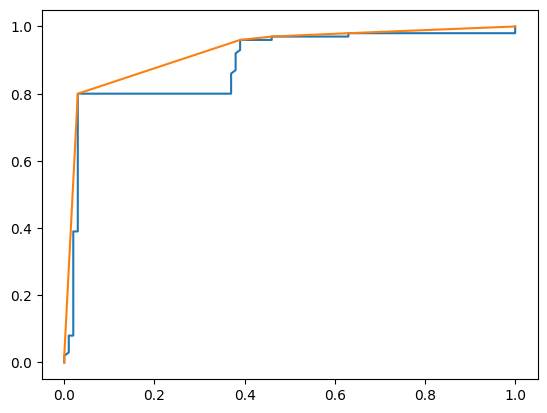

In [ ]:
plt.plot(fprs[0], tprs[0])
plt.plot(fprs0, tprs0)

In [ ]:
fprs[0][hull.vertices], tprs[0][hull.vertices]

(array([1.  , 0.99, 0.46, 0.38, 0.  , 0.01, 0.07, 0.2 ]),
 array([1.  , 1.  , 0.97, 0.96, 0.  , 0.  , 0.03, 0.12]))

In [ ]:
np.array(values)[sorting]

array([-12.97435897, -11.31428571, -11.15151515, ...,   8.44642857,
         9.37931034,   9.91208791])

In [ ]:
n_curves = len(fprs)
h_curves = n_curves // 20
np.mean(integrate_roc_curves(fprs[:h_curves], tprs[:h_curves])), np.mean(integrate_roc_curves(fprs[-h_curves:], tprs[-h_curves:]))

(np.float64(0.7404474), np.float64(0.7465643))

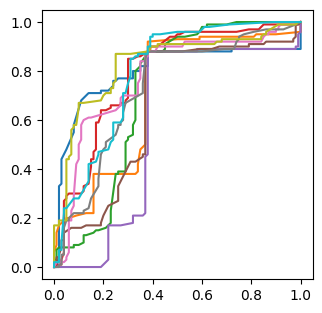

In [ ]:
plt.figure(figsize=(3.5, 3.5))
for idx in range(len(fprs)//2, len(fprs)//2 + 10):
    plt.plot(fprs[idx], tprs[idx])

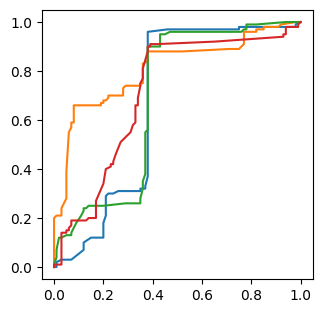

In [ ]:
plt.figure(figsize=(3.5, 3.5))
for idx in range(0, 4):
    plt.plot(fprs[idx], tprs[idx])

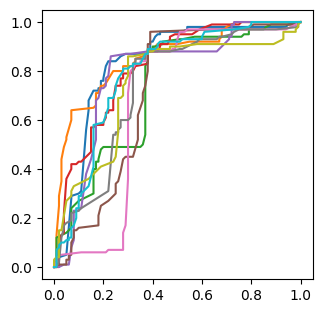

In [ ]:
plt.figure(figsize=(3.5, 3.5))
for idx in range(len(fprs) - 10, len(fprs)):
    plt.plot(fprs[idx], tprs[idx])

In [ ]:
bins = np.percentile(data['n_nodes'], np.linspace(20, 100, 8))
bins = (bins[:-1] + bins[1:])/2
while bins[0] == bins[1]:
    bins = bins[1:]
#bins = np.hstack([bins, [np.percentile(data['n_nodes'], 95)]])
#bins = np.array([6, 15, 25, 45, 90, 135])

In [ ]:
data.columns

Index(['dataset', 'classifier', 'classifier_params', 'p', 'n', 'p_train',
       'n_train', 'auc', 'auc_train', 'fprs', 'tprs', 'thresholds', 'n_nodes',
       'fprs_train', 'tprs_train', 'thresholds_train', 'n_nodes_train', 'acc',
       'sens', 'spec', 'best_acc', 'best_sens', 'best_spec', 'acc_train',
       'sens_train', 'spec_train', 'best_acc_train', 'best_sens_train',
       'best_spec_train', 'fracs', 'exp_fpr', 'exp_tpr', 'r2_fpr', 'r2_tpr',
       'r2_roc', 'auc_min', 'auc_min_best', 'auc_max', 'auc_max_best',
       'auc_maxa_best', 'auc_rmin', 'auc_rmin_best', 'auc_min_max_normal_nw',
       'auc_min_max_best_nw', 'auc_rmin_max_normal_nw', 'auc_rmin_max_best_nw',
       'auc_min_maxa_best_nw', 'auc_rmin_maxa_best_nw',
       'auc_integral_joint_best', 'aijb_p_fpr', 'aijb_p_tpr',
       'auc_integral_roc', 'air_p_fpr', 'air_p_tpr', 'auc_integral_roc_best',
       'airb_p_fpr', 'airb_p_tpr', 'auc_integral_roc2_best', 'air2b_p_fpr',
       'air2b_p_tpr', 'max_acc_integral', 'm

In [ ]:
fprs, tprs, air_p_fpr, air_p_tpr, spec, sens = data.iloc[0][['fprs', 'tprs', 'air_p_fpr', 'air_p_tpr', 'spec', 'sens']]

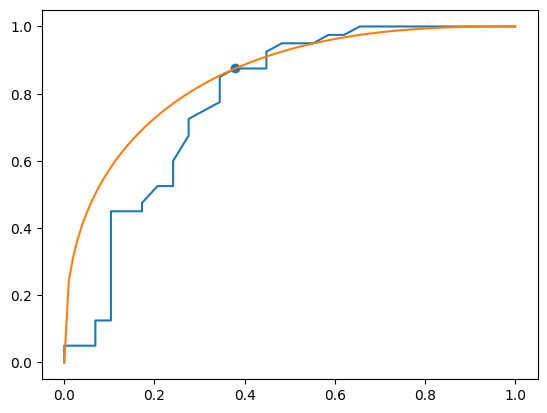

In [ ]:
x = np.linspace(0, 1, 100)
plt.plot(np.array(eval(fprs)), np.array(eval(tprs)))
plt.plot(x, (1 - (1 - x)**air_p_fpr)**(1/air_p_fpr))
plt.scatter([1 - spec], [sens])

In [ ]:
def downsample_roc_0(fpr0, tpr0, p, n_nodes, n_samples):
    fprs = np.zeros((n_samples, n_nodes + 3), dtype=float)
    tprs = np.zeros((n_samples, n_nodes + 3), dtype=float)

    fprs[:, 1] = fpr0
    fprs[:, 2] = 1.0
    #tprs[:, 1] = (1 - (1 - fpr0)**p)**(1/p)
    tprs[:, 1] = tpr0
    tprs[:, 2] = 1.0

    random_samples = np.random.random_sample((n_samples, n_nodes))
    fprs[:, 3:] = random_samples
    tprs[:, 3:] = (1 - (1 - random_samples)**p)**(1/p)

    sorting = np.argsort(fprs)
    fprs = fprs[np.arange(fprs.shape[0])[:, None], sorting]
    tprs = tprs[np.arange(fprs.shape[0])[:, None], sorting]

    return fprs, tprs

In [ ]:
def downsample_roc_1(fpr0, tpr0, exp, p, n, n_min_samples, n_samples=20):
    if exp == -1:
        if fpr0 < 1e-6 and tpr0 > 1 - 1e-6:
            return 1.0
        if fpr0 < 1e-6 and tpr0 < 1e-6:
            return 0.5
        if fpr0 > 1 - 1e-6 and tpr0 > 1 - 1e-6:
            return 0.5
    
    #fpr0 = min(max(1/n, fpr0), 1.0 - 1/n)
    #tpr0 = min(max(1/p, tpr0), 1.0 - 1/p)
    #max_nodes = min(int(np.sqrt(n_min_samples) * 2 + 2), 100)


    if n_min_samples > 100:
        return np.mean(integrate_roc_curves(*downsample_roc_0(fpr0, tpr0, exp, 100, 1)))

    means = []
    #for n_nodes in np.logspace(0, np.log(n_min_samples), 5):
    for n_nodes in np.linspace(1, n_min_samples, 8):
        means.append(np.mean(integrate_roc_curves(*downsample_roc_0(fpr0, tpr0, exp, min(int(n_nodes)-1, 100), n_samples))))
    #means = []
    #means.append(integrate_roc_curves(*downsample_roc_0(fpr0, tpr0, exp, 0, n_samples)))
    #means.append(integrate_roc_curves(*downsample_roc_0(fpr0, tpr0, exp, 200, n_samples)))
    return np.mean(means)

In [ ]:
data['auc_integral_roc3'] = data.apply(lambda row: downsample_roc_1(1.0 - row['spec'], row['sens'], row['air_p_fpr'], row['p'], row['n'], row['n_min_samples']), axis=1)

In [ ]:
data['auc_integral_roc3_best'] = data.apply(lambda row: downsample_roc_1(1.0 - row['best_spec'], row['best_sens'], row['air2b_p_fpr'], row['p'], row['n'], row['n_min_samples']), axis=1)

In [ ]:
fprs, tprs = downsample_roc_0(0.024, 0.776, 7.22, 8, 10)

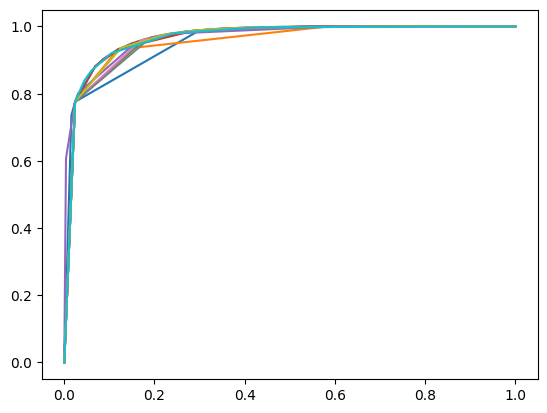

In [ ]:
for idx in range(len(fprs)):
    plt.plot(fprs[idx], tprs[idx])

In [ ]:
downsample_roc_1(0.024, 0.776, 7.22, 10, 100, 100, 20)


np.float64(0.957406984628173)

In [ ]:
data['n_nodes_bin'] = data.apply(lambda row: bins[np.argmin(np.abs(bins - row['n_nodes']))], axis=1)

In [ ]:
data['auc_final'] = (data['auc_min_max_normal_nw'] + data['auc_integral_roc'])/2
data['auc_final_best'] = (data['auc_min_max_best_nw'] + data['auc_integral_joint_best'])/2

data['max_acc_min_max'] = (data['max_acc_min'] + data['max_acc_max'])/2

data['max_acc_final'] = (data['max_acc_integral'] + data['max_acc_min_max'])/2

In [ ]:
print(equalize)

auc


In [ ]:
if equalize == 'auc':
    n_samples = 1000

    tmp = []
    lower_bounds = np.linspace(0.5, 1.0, 11)
    for lower, upper in zip(lower_bounds[:-1], lower_bounds[1:]):
        if upper == 1.0:
            tmp2 = data[(data['auc'] >= lower) & (data['auc'] <= upper)]
        else:
            tmp2 = data[(data['auc'] >= lower) & (data['auc'] < upper)]
        if len(tmp2) == 0:
            continue
        if len(tmp2) > n_samples:
            tmp.append(tmp2.sample(n_samples, random_state=5, replace=False))
        else:
            tmp.append(tmp2.sample(n_samples, random_state=5, replace=True))
    data_eq = pd.concat(tmp)
else:
    data_eq = data

if equalize == 'n_nodes_bins':
    n_samples = 1000

    tmp = []
    bins = data['n_nodes_bin'].drop_duplicates().values
    for bin in bins:
        tmp2 = data[data['n_nodes_bin'] == bin]
        if len(tmp2) > n_samples:
            tmp.append(tmp2.sample(n_samples, random_state=5, replace=False))
        else:
            tmp.append(tmp2.sample(n_samples, random_state=5, replace=True))
    data_eq = pd.concat(tmp)
else:
    data_eq = data



if noedge:
    data_eq = data_eq[(~data_eq['best_sens'].isin([0])) & (~data_eq['best_spec'].isin([0]))]
    data_eq = data_eq[(~data_eq['sens'].isin([0])) & (~data_eq['spec'].isin([0]))]

    data = data[(~data['best_sens'].isin([0])) & (~data['best_spec'].isin([0]))]
    data = data[(~data['sens'].isin([0])) & (~data['spec'].isin([0]))]

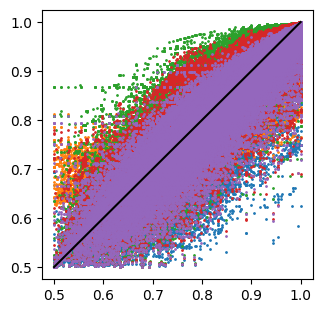

In [ ]:
plt.figure(figsize=(3.5, 3.5))
plt.plot([0.5, 1.0], [0.5, 1.0], color='black')
plt.scatter(data_eq['auc'], data_eq['auc_min_max_normal_nw'], s=1)
plt.scatter(data_eq['auc'], data_eq['auc_rmin_max_normal_nw'], s=1)
plt.scatter(data_eq['auc'], data_eq['auc_integral_roc'], s=1)
plt.scatter(data_eq['auc'], data_eq['auc_integral_roc3'], s=1)
plt.scatter(data_eq['auc'], data_eq['auc_final'], s=1)

In [ ]:
skew(data_eq['auc'] - data_eq['auc_final'])

np.float64(0.24332751270234315)

In [ ]:
skewtest(data_eq['auc'] - data_eq['auc_final'])

SkewtestResult(statistic=np.float64(30.416331709877255), pvalue=np.float64(3.341124725435175e-203))

In [ ]:
(r2_score(data_eq['auc'], data_eq['auc_min_max_normal_nw']),
r2_score(data_eq['auc'], data_eq['auc_rmin_max_normal_nw']),
r2_score(data_eq['auc'], data_eq['auc_integral_roc']),
r2_score(data_eq['auc'], data_eq['auc_integral_roc3']),
r2_score(data_eq['auc'], data_eq['auc_final']))

(0.7784937125677939,
 0.8370274748891644,
 0.8340542650896177,
 0.8830944575406338,
 0.8895450594609058)

In [ ]:
def calculate_r2(pdf, target):
    """if np.std(pdf[target]) < 1e-6:
        return None
    else:"""
    #r2 = r2_score(pdf['auc'], pdf[target])
    r2 = mean_absolute_percentage_error(pdf['auc'], pdf[target])
    if r2 < 0:
        return 0.0
    else:
        return r2

In [ ]:
tmp = data_eq.groupby(['n_nodes_bin', 'classifier']).apply(lambda pdf: 
        pd.Series({'r2_min_max': calculate_r2(pdf, 'auc_min_max_normal_nw'),
                   'r2_rmin_max': calculate_r2(pdf, 'auc_rmin_max_normal_nw'),
                   'r2_integral': calculate_r2(pdf, 'auc_integral_roc'),
                   'r2_final': calculate_r2(pdf, 'auc_final')})).reset_index(drop=False)

/tmp/ipykernel_469432/251532501.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  tmp = data_eq.groupby(['n_nodes_bin', 'classifier']).apply(lambda pdf:


In [ ]:
tmp

,n_nodes_bin,classifier,r2_min_max,r2_rmin_max,r2_integral,r2_final
0,3.5,DecisionTreeClassifier,0.001183,0.063713,0.094139,0.047123
1,3.5,KNeighborsClassifier,0.017703,0.026180,0.030058,0.018576
2,3.5,RandomForestClassifier,0.017635,0.016732,0.020177,0.018859
3,3.5,SVC,0.009129,0.009485,0.010788,0.009937
4,3.5,XGBClassifier,0.004337,0.004117,0.004539,0.004434
5,5.0,DecisionTreeClassifier,0.033553,0.049348,0.072302,0.036053
6,5.0,KNeighborsClassifier,0.055728,0.051307,0.046499,0.037543
7,5.0,RandomForestClassifier,0.044313,0.039734,0.033748,0.036778
8,5.0,SVC,0.039294,0.037815,0.036270,0.036266
9,5.0,XGBClassifier,0.035588,0.031307,0.017871,0.025191


In [ ]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', 'black', 'yellow']

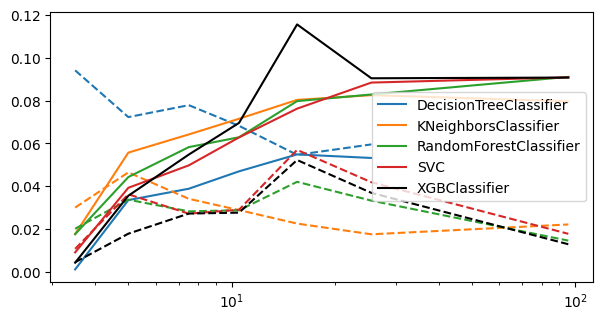

In [ ]:
plt.figure(figsize=(7, 3.5))
for idx, classifier in enumerate(tmp['classifier'].drop_duplicates()):
    tmp2 = tmp[tmp['classifier'] == classifier]
    plt.plot(tmp2['n_nodes_bin'], tmp2['r2_min_max'], ls='solid', c=colors[idx], label=classifier)
    plt.plot(tmp2['n_nodes_bin'], tmp2['r2_integral'], ls='--', c=colors[idx])
    #plt.plot(tmp2['n_nodes_bin'], tmp2['r2_final'], ls=':', c=colors[idx])
plt.xscale('log')
plt.legend()

In [ ]:
tmp = data.groupby('n_nodes_bin').apply(lambda pdf: 
        pd.Series({'r2_min_max': r2_score(pdf['auc'], pdf['auc_min_max_normal_nw']),
                   'r2_rmin_max': r2_score(pdf['auc'], pdf['auc_rmin_max_normal_nw']),
                   'r2_integral': r2_score(pdf['auc'], pdf['auc_integral_roc']),
                   'r2_integral3': r2_score(pdf['auc'], pdf['auc_integral_roc3']),
                   'r2_final': r2_score(pdf['auc'], pdf['auc_final']),
                   'mape_min_max': mean_absolute_percentage_error(pdf['auc'], pdf['auc_min_max_normal_nw']),
                   'mape_rmin_max': mean_absolute_percentage_error(pdf['auc'], pdf['auc_rmin_max_normal_nw']),
                   'mape_integral': mean_absolute_percentage_error(pdf['auc'], pdf['auc_integral_roc']),
                   'mape_integral3': mean_absolute_percentage_error(pdf['auc'], pdf['auc_integral_roc3']),
                   'mape_final': mean_absolute_percentage_error(pdf['auc'], pdf['auc_final']),
                   'count': len(pdf)})).reset_index(drop=False)

/tmp/ipykernel_469432/156908297.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  tmp = data.groupby('n_nodes_bin').apply(lambda pdf:


In [ ]:
tmp

,n_nodes_bin,r2_min_max,r2_rmin_max,r2_integral,r2_integral3,r2_final,mape_min_max,mape_rmin_max,mape_integral,mape_integral3,mape_final,count
0,3.5,0.983482,0.889170,0.799409,0.898475,0.940539,0.006752,0.039250,0.055688,0.038409,0.030194,33055.0
1,5.0,0.787615,0.838611,0.833591,0.860622,0.872976,0.046506,0.044770,0.042237,0.037063,0.035452,9603.0
2,7.5,0.673562,0.793060,0.856264,0.849325,0.853182,0.056814,0.046542,0.032966,0.034738,0.035355,13988.0
3,10.5,0.530409,0.729487,0.867057,0.855771,0.833886,0.066410,0.050518,0.029519,0.032227,0.036034,10183.0
4,15.5,0.313188,0.708333,0.753902,0.761431,0.718048,0.086906,0.055391,0.045478,0.044669,0.050423,9247.0
5,25.5,0.452194,0.755964,0.866370,0.884780,0.823130,0.086823,0.055376,0.036564,0.032694,0.044360,16855.0
6,95.5,0.095413,0.602445,0.959846,0.961079,0.781581,0.090860,0.053952,0.015220,0.014847,0.042186,3534.0


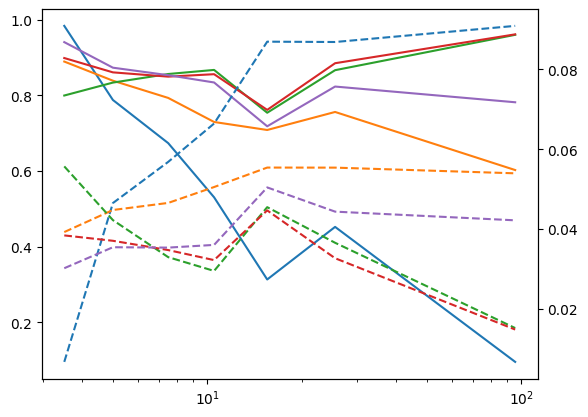

In [ ]:
ax1 = plt.subplot()
ax2 = ax1.twinx()
ax1.plot(tmp['n_nodes_bin'], tmp['r2_min_max'], ls='solid')
ax1.plot(tmp['n_nodes_bin'], tmp['r2_rmin_max'], ls='solid')
ax1.plot(tmp['n_nodes_bin'], tmp['r2_integral'], ls='solid')
ax1.plot(tmp['n_nodes_bin'], tmp['r2_integral3'], ls='solid')
ax1.plot(tmp['n_nodes_bin'], tmp['r2_final'], ls='solid')
ax2.plot(tmp['n_nodes_bin'], tmp['mape_min_max'], ls='dashed')
ax2.plot(tmp['n_nodes_bin'], tmp['mape_rmin_max'], ls='dashed')
ax2.plot(tmp['n_nodes_bin'], tmp['mape_integral'], ls='dashed')
ax2.plot(tmp['n_nodes_bin'], tmp['mape_integral3'], ls='dashed')
ax2.plot(tmp['n_nodes_bin'], tmp['mape_final'], ls='dashed')
plt.xscale('log')

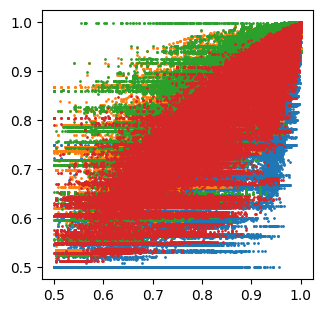

In [ ]:
plt.figure(figsize=(3.5, 3.5))
plt.scatter(data_eq['auc'], data_eq['auc_min_max_best_nw'], s=1)
plt.scatter(data_eq['auc'], data_eq['auc_integral_roc_best'], s=1)
plt.scatter(data_eq['auc'], data_eq['auc_integral_joint_best'], s=1)
plt.scatter(data_eq['auc'], data_eq['auc_final_best'], s=1)

In [ ]:
(r2_score(data_eq['auc'], data_eq['auc_min_max_best_nw']),
r2_score(data_eq['auc'], data_eq['auc_rmin_max_best_nw']),
r2_score(data_eq['auc'], data_eq['auc_min_maxa_best_nw']),
r2_score(data_eq['auc'], data_eq['auc_rmin_maxa_best_nw']),
r2_score(data_eq['auc'], data_eq['auc_integral_joint_best']),
r2_score(data_eq['auc'], data_eq['auc_integral_roc_best']),
r2_score(data_eq['auc'], data_eq['auc_integral_roc2_best']),
r2_score(data_eq['auc'], data_eq['auc_integral_roc3_best']),
r2_score(data_eq['auc'], data_eq['auc_final_best']))

(0.4375081353480522,
 0.7559346699740608,
 0.21956721060712336,
 0.7828257506382936,
 0.7952243989433289,
 0.7779776869666177,
 0.7915070885335033,
 0.8512798465715338,
 0.7969244653772841)

In [ ]:
tmp = data_eq.groupby(['n_nodes_bin', 'classifier']).apply(lambda pdf: 
        pd.Series({'r2_min_max': calculate_r2(pdf, 'auc_min_max_best_nw'),
                   'r2_rmin_max': calculate_r2(pdf, 'auc_rmin_max_best_nw'),
                   'r2_integral': calculate_r2(pdf, 'auc_integral_joint_best'),
                   'r2_final': calculate_r2(pdf, 'auc_final_best'),
                   'count': len(pdf)})).reset_index(drop=False)

/tmp/ipykernel_469432/3926694275.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  tmp = data_eq.groupby(['n_nodes_bin', 'classifier']).apply(lambda pdf:


In [ ]:
tmp

,n_nodes_bin,classifier,r2_min_max,r2_rmin_max,r2_integral,r2_final,count
0,3.5,DecisionTreeClassifier,0.044735,0.075759,0.083475,0.051562,16602.0
1,3.5,KNeighborsClassifier,0.034937,0.030618,0.040612,0.028712,4655.0
2,3.5,RandomForestClassifier,0.000514,0.000560,0.013490,0.006982,4031.0
3,3.5,SVC,0.003866,0.004437,0.019119,0.011492,3417.0
4,3.5,XGBClassifier,0.000589,0.000609,0.011368,0.005940,4350.0
5,5.0,DecisionTreeClassifier,0.064555,0.061820,0.072351,0.046318,1057.0
6,5.0,KNeighborsClassifier,0.102267,0.065550,0.058676,0.058259,4469.0
7,5.0,RandomForestClassifier,0.032441,0.031799,0.024940,0.026316,1307.0
8,5.0,SVC,0.047097,0.046663,0.035304,0.040409,1509.0
9,5.0,XGBClassifier,0.026659,0.024723,0.016289,0.019139,1261.0


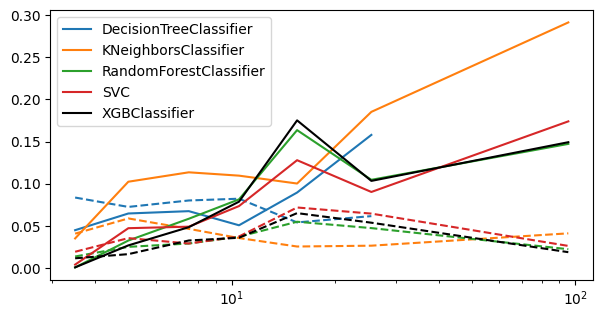

In [ ]:
plt.figure(figsize=(7, 3.5))
for idx, classifier in enumerate(tmp['classifier'].drop_duplicates()):
    tmp2 = tmp[tmp['classifier'] == classifier]
    plt.plot(tmp2['n_nodes_bin'], tmp2['r2_min_max'], ls='solid', c=colors[idx], label=classifier)
    plt.plot(tmp2['n_nodes_bin'], tmp2['r2_integral'], ls='--', c=colors[idx])
    #plt.plot(tmp2['n_nodes_bin'], tmp2['r2_final'], ls=':', c=colors[idx])
plt.xscale('log')
plt.legend()

In [ ]:
tmp = data.groupby('n_nodes_bin').apply(lambda pdf: 
        pd.Series({'r2_min_max': r2_score(pdf['auc'], pdf['auc_min_max_best_nw']),
                   'r2_rmin_max': r2_score(pdf['auc'], pdf['auc_rmin_max_best_nw']),
                   'r2_rmin_maxa': r2_score(pdf['auc'], pdf['auc_rmin_maxa_best_nw']),
                   'r2_integral': r2_score(pdf['auc'], pdf['auc_integral_joint_best']),
                   'r2_final': r2_score(pdf['auc'], pdf['auc_final_best']),
                   'mape_min_max': mean_absolute_percentage_error(pdf['auc'], pdf['auc_min_max_best_nw']),
                   'mape_rmin_max': mean_absolute_percentage_error(pdf['auc'], pdf['auc_rmin_max_best_nw']),
                   'mape_rmin_maxa': mean_absolute_percentage_error(pdf['auc'], pdf['auc_rmin_maxa_best_nw']),
                   'mape_integral': mean_absolute_percentage_error(pdf['auc'], pdf['auc_integral_joint_best']),
                   'mape_final': mean_absolute_percentage_error(pdf['auc'], pdf['auc_final_best']),
                   'count': len(pdf)})).reset_index(drop=False)

/tmp/ipykernel_469432/3403290292.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  tmp = data.groupby('n_nodes_bin').apply(lambda pdf:


In [ ]:
tmp

,n_nodes_bin,r2_min_max,r2_rmin_max,r2_rmin_maxa,r2_integral,r2_final,mape_min_max,mape_rmin_max,mape_rmin_maxa,mape_integral,mape_final,count
0,3.5,0.855987,0.838767,0.924205,0.821989,0.914600,0.027928,0.042969,0.024552,0.052762,0.032762,33055.0
1,5.0,0.518279,0.772148,0.804733,0.775647,0.792961,0.070015,0.052217,0.047078,0.046351,0.044655,9603.0
2,7.5,0.303148,0.735430,0.741444,0.783637,0.721241,0.074924,0.050763,0.049504,0.038919,0.044608,13988.0
3,10.5,0.031451,0.660012,0.627885,0.760746,0.697277,0.085465,0.054797,0.057306,0.037373,0.043697,10183.0
4,15.5,-0.987152,0.589326,0.487098,0.591234,0.356296,0.143350,0.064488,0.073961,0.056598,0.074113,9247.0
5,25.5,-0.050939,0.593138,0.593797,0.725783,0.696474,0.103285,0.067288,0.067079,0.053854,0.050372,16855.0
6,95.5,-2.320882,-0.219937,-0.594595,0.920793,0.110975,0.158608,0.080028,0.107676,0.022291,0.077034,3534.0


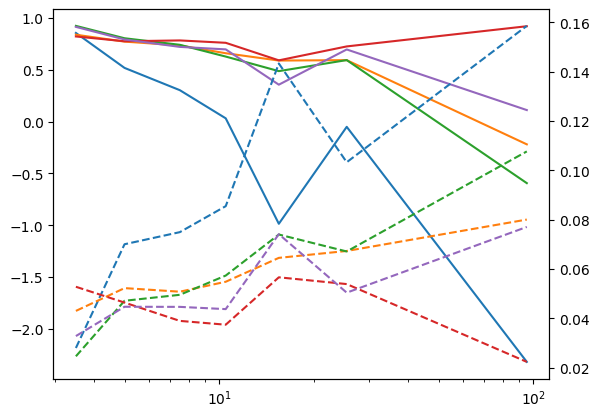

In [ ]:
ax1 = plt.subplot()
ax2 = plt.twinx()
ax1.plot(tmp['n_nodes_bin'], tmp['r2_min_max'])
ax1.plot(tmp['n_nodes_bin'], tmp['r2_rmin_max'])
ax1.plot(tmp['n_nodes_bin'], tmp['r2_rmin_maxa'])
ax1.plot(tmp['n_nodes_bin'], tmp['r2_integral'])
ax1.plot(tmp['n_nodes_bin'], tmp['r2_final'])
ax2.plot(tmp['n_nodes_bin'], tmp['mape_min_max'], ls='dashed')
ax2.plot(tmp['n_nodes_bin'], tmp['mape_rmin_max'], ls='dashed')
ax2.plot(tmp['n_nodes_bin'], tmp['mape_rmin_maxa'], ls='dashed')
ax2.plot(tmp['n_nodes_bin'], tmp['mape_integral'], ls='dashed')
ax2.plot(tmp['n_nodes_bin'], tmp['mape_final'], ls='dashed')
plt.xscale('log')

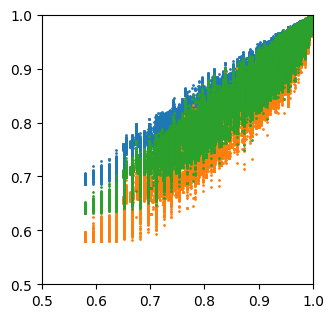

In [ ]:
plt.figure(figsize=(3.5, 3.5))
plt.xlim((0.5, 1.0))
plt.ylim((0.5, 1.0))
plt.scatter(data_eq['best_acc'], data_eq['max_acc_min_max'], s=1)
plt.scatter(data_eq['best_acc'], data_eq['max_acc_integral'], s=1)
plt.scatter(data_eq['best_acc'], data_eq['max_acc_final'], s=1)

In [ ]:
skew(data_eq['best_acc'] - data_eq['max_acc_final'])

np.float64(0.44253356628196827)

In [ ]:
(r2_score(data_eq['best_acc'], data_eq['max_acc_min_max']),
r2_score(data_eq['best_acc'], data_eq['max_acc_integral']),
r2_score(data_eq['best_acc'], data_eq['max_acc_final']))

(0.8797075975896895, 0.896192240515261, 0.9385121243711768)

In [ ]:
tmp = data.groupby('n_nodes_bin').apply(lambda pdf: 
        pd.Series({'r2_min_max': r2_score(pdf['best_acc'], pdf['max_acc_min_max']),
                   'r2_integral': r2_score(pdf['best_acc'], pdf['max_acc_integral']),
                   'r2_final': r2_score(pdf['best_acc'], pdf['max_acc_final'])}))

/tmp/ipykernel_469432/3505634563.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  tmp = data.groupby('n_nodes_bin').apply(lambda pdf:


In [ ]:
tmp

,r2_min_max,r2_integral,r2_final
n_nodes_bin,,,
3.5,0.892554,0.891084,0.928950
5.0,0.862384,0.839413,0.898022
7.5,0.875591,0.857642,0.919754
10.5,0.874080,0.884961,0.938862
15.5,0.764930,0.902411,0.920683
25.5,0.769743,0.828169,0.929168
95.5,0.791451,0.974774,0.953363
